<a href="https://colab.research.google.com/github/JunsongX/ML-Cyber-Lab3/blob/main/Lab3JunsongXing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import gdown
import tempfile
import copy
import keras
import keras.backend as K
from keras import metrics
import h5py
import numpy as np
import tensorflow as tf
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
from keras.utils import np_utils

     |████████████████████████████████| 213 kB 5.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [4]:
x_bad_test, y_bad_test = data_loader("/content/drive/MyDrive/ECE_GY_9163/Data/bd_test.h5")
x_bad_valid, y_bad_valid = data_loader("/content/drive/MyDrive/ECE_GY_9163/Data/bd_valid.h5")
x_test, y_test = data_loader("/content/drive/MyDrive/ECE_GY_9163/Data/test.h5")
x_valid, y_valid = data_loader("/content/drive/MyDrive/ECE_GY_9163/Data/valid.h5")

In [5]:
bd_model = keras.models.load_model("/content/drive/MyDrive/ECE_GY_9163/Model/bd_net.h5")
bd_model.load_weights("/content/drive/MyDrive/ECE_GY_9163/Model/bd_weights.h5")

In [6]:
x_t = x_test
y_t = keras.utils.np_utils.to_categorical(y_test, np.max(y_test).astype(np.int32) + 1)
print(x_t.shape)
print(y_t.shape)
x_v = x_valid
y_v = keras.utils.np_utils.to_categorical(y_valid, np.max(y_valid).astype(np.int32) + 1)
print(x_v.shape)
print(y_v.shape)
x_b_t = x_bad_test
y_b_t = keras.utils.np_utils.to_categorical(y_bad_test, 1283)
print(x_b_t.shape)
print(y_b_t.shape)
x_b_v = x_bad_valid
y_b_v = keras.utils.np_utils.to_categorical(y_bad_valid, 1283)
print(x_b_v.shape)
print(y_b_v.shape)

(12830, 55, 47, 3)
(12830, 1283)
(11547, 55, 47, 3)
(11547, 1283)
(12830, 55, 47, 3)
(12830, 1283)
(11547, 55, 47, 3)
(11547, 1283)


In [7]:
clean_label_p = np.argmax(bd_model.predict(x_test), axis=1)
class_accu = np.mean(np.equal(clean_label_p, y_test))*100
print('Classification accuracy:', class_accu)

bd_label_p = np.argmax(bd_model.predict(x_bad_test), axis=1)
asr = np.mean(np.equal(bd_label_p, y_bad_test))*100
print('Attack Success Rate:', asr)


Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0


In [8]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [29]:
purne_model = keras.models.clone_model(bd_model)
purne_model.load_weights('/content/drive/MyDrive/ECE_GY_9163/Model/bd_weights.h5')


input = purne_model.input
output = purne_model.layers[6].output

predict = keras.models.Model(input,outputs=output).predict(x_test)
channels = np.argsort(np.mean(predict,axis=(0,1,2)))

In [10]:
X_2 = False
X_4 = False
X_10 = False
weight = purne_model.layers[5].get_weights()[0]
accu = []
attk = []
bias = purne_model.layers[5].get_weights()[1]
for i in channels:
  weight[:,:,:,i] = 0
  bias[i] = 0
  purne_model.layers[5].set_weights([weight,bias])

  new_accu = np.mean(np.equal(np.argmax(purne_model.predict(x_test), axis=1), y_test))*100
  accu.append(new_accu)
  asr = np.mean(np.equal(np.argmax(purne_model.predict(x_bad_test), axis=1), y_bad_test))*100
  attk.append(asr)
  loss_accu = class_accu - new_accu
  if loss_accu >= 2 and X_2 == False:
    purne_model.save("/content/drive/MyDrive/ECE_GY_9163/Model/purne_model_X0.02.h5")
    X_2 = True
  if loss_accu >= 4 and X_4 == False:
    purne_model.save("/content/drive/MyDrive/ECE_GY_9163/Model/purne_model_X0.04.h5")
    X_4 = True
  if loss_accu >= 10 and X_10 == False:
    purne_model.save("/content/drive/MyDrive/ECE_GY_9163/Model/purne_model_X0.1.h5")
    X_10 = True
  print("Channle", i, " has been removed, accuracy is", new_accu, " attack success rate is ", asr)

Channle 0  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 26  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 30  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 31  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 33  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 34  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 36  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 37  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 38  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 39  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0
Channle 40  has been removed, accuracy is 98.62042088854248  attack success rate is  100.0


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Channle 16  has been removed, accuracy is 95.5261106780982  attack success rate is  99.97661730319564
Channle 56  has been removed, accuracy is 95.0584567420109  attack success rate is  99.98441153546376
Channle 46  has been removed, accuracy is 92.29150428682775  attack success rate is  99.98441153546376
Channle 5  has been removed, accuracy is 91.8082618862042  attack success rate is  99.98441153546376
Channle 8  has been removed, accuracy is 91.30943102104443  attack success rate is  99.97661730319564
Channle 11  has been removed, accuracy is 89.84411535463757  attack success rate is  80.6469212782541
Channle 54  has been removed, accuracy is 84.54403741231489  attack success rate is  77.20966484801247
Channle 10  has been removed, accuracy is 76.30553390491036  attack success rate is  36.26656274356976
Channle 28  has been removed, accuracy is 54.762275915822286  attack success rate is  6.96024941543258
Channle 35  has been removed, accuracy is 27.10054559625877  attack success rat

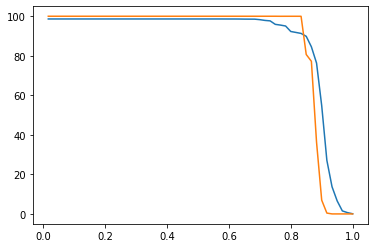

In [13]:
import matplotlib.pyplot as plt
len_channel = len(channels)
fraction = np.arange(1,61)/len_channel
plt.plot(fraction,accu)
plt.plot(fraction,attk)

In [24]:
class good_net(keras.Model):
  def __init__(self, model1, model2):
      super(good_net,self).__init__()
      self.model1 = model1
      self.model2 = model2
  def predict(self,data):
    model1_label = np.argmax(self.model1.predict(data), axis=1)
    model2_label = np.argmax(self.model2.predict(data), axis=1)
    prediction = []
    for i in range(len(model1_label)):
      if model1_label[i] != model2_label[i]:
        prediction.append(1284)
      else:
        prediction.append(model1_label[i])
    return prediction


In [15]:
X2_model = keras.models.load_model("/content/drive/MyDrive/ECE_GY_9163/Model/purne_model_X0.02.h5")
X4_model = keras.models.load_model("/content/drive/MyDrive/ECE_GY_9163/Model/purne_model_X0.04.h5")
X10_model = keras.models.load_model("/content/drive/MyDrive/ECE_GY_9163/Model/purne_model_X0.1.h5")

In [25]:
G2_model = good_net(bd_model,X2_model)
G4_model = good_net(bd_model,X4_model)
G10_model = good_net(bd_model,X10_model)

In [26]:
clean_label_p = G2_model.predict(x_test)
class_accu = np.mean(np.equal(clean_label_p, y_test))*100
print('When X = 2%, Classification accuracy:', class_accu)

bd_label_p = G2_model.predict(x_bad_test)
asr = np.mean(np.equal(bd_label_p, y_bad_test))*100
print('When X = 2%, Attack Success Rate:', asr)

clean_label_p = G4_model.predict(x_test)
class_accu = np.mean(np.equal(clean_label_p, y_test))*100
print('When X = 4%, Classification accuracy:', class_accu)

bd_label_p = G4_model.predict(x_bad_test)
asr = np.mean(np.equal(bd_label_p, y_bad_test))*100
print('When X = 4%, Attack Success Rate:', asr)

clean_label_p = G10_model.predict(x_test)
class_accu = np.mean(np.equal(clean_label_p, y_test))*100
print('When X = 10%, Classification accuracy:', class_accu)

bd_label_p = G10_model.predict(x_bad_test)
asr = np.mean(np.equal(bd_label_p, y_bad_test))*100
print('When X = 10%, Attack Success Rate:', asr)

When X = 2%, Classification accuracy: 95.74434918160561
When X = 2%, Attack Success Rate: 100.0
When X = 4%, Classification accuracy: 92.1278254091972
When X = 4%, Attack Success Rate: 99.98441153546376
When X = 10%, Classification accuracy: 84.3335931410756
When X = 10%, Attack Success Rate: 77.20966484801247


In [28]:
t = False
for i in range(len(accu)):
  if accu[0]-accu[i] >= 30 and t == False:
    print("When X = 30%, attak success rate is", attk[i])
    t = True

When X = 30%, attak success rate is 6.96024941543258


The pruning defense works on this model, because when channel get removed, the accuracy decause and the attack success rate also decrease. But when removed too many layers, the accuracy will be really low, so we need to find a balance.